In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from astropy.constants import c
import astropy.units as u
from scipy.ndimage import gaussian_filter1d

# import the main class
from funcs.auroralring import AuroralRing

import emcee
import corner


In [10]:

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 70 * np.pi/180


# rotation period in days
P_rot = 2.845 / 24.
omega = 2 * np.pi / P_rot


# stellar radius in solar radii
R_star = (1.07 * u.R_jup).to(u.R_sun).value



vmax = omega * R_star * 695700. / 86400. # km/s

df = pd.read_csv('data/lsr_norm_spectra_minspec.csv', index_col=0, header=[0,1])


# select only index values between 6559 and 6566 
df = df.loc[(df.index > 6560.) & (df.index < 6565.5)]


x = df.index.values
diffx = np.diff(x)
vbins = np.linspace(x[0]-diffx[0]/2, x[-1]+diffx[-1]/2, len(x)+1)
vbins = ((vbins - 6562.8) / 6562.8 * c).to(u.km/u.s).value
vmids = (vbins[1:] + vbins[:-1]) / 2

# for each column in df, select the median subcolumn
ys = []
ystds = []

for col in df.columns.levels[0]:
    for subcol in df.columns.levels[1]:
        if subcol == "median":
            ys.append(df[col, subcol].values)
        elif subcol == "std":
            ystds.append(df[col, subcol].values)

# invert the order of ys and ystds
ys = ys[::-1]
ystds = ystds[::-1]

ys = np.array(ys)
ystds = np.array(ystds).astype(float)

N = 11
subspecs = 3
midphases = np.linspace(0, 2*np.pi, N*subspecs - (subspecs-1))
alphas_0 = (midphases[1:] + midphases[:-1]) / 2

ddv = vmids[1] - vmids[0]

vmids.shape, vbins[0], vbins[-1], alphas_0/np.pi/2

((191,),
 -128.04263601490675,
 123.77278494575917,
 array([0.01666667, 0.05      , 0.08333333, 0.11666667, 0.15      ,
        0.18333333, 0.21666667, 0.25      , 0.28333333, 0.31666667,
        0.35      , 0.38333333, 0.41666667, 0.45      , 0.48333333,
        0.51666667, 0.55      , 0.58333333, 0.61666667, 0.65      ,
        0.68333333, 0.71666667, 0.75      , 0.78333333, 0.81666667,
        0.85      , 0.88333333, 0.91666667, 0.95      , 0.98333333]))

In [11]:
def model(vbins, vmids, imag, phimin, dphi, alpha_0, ampl,  broaden, amp_cos, off_cos,foreshortening=True): 

    # inclination of magnetic axis in radians relative to rotation axis
    i_mag = imag * np.pi / 180

    # upper latitude of ring around magnetic axis in radians
    PHI_max = (phimin + dphi) * np.pi / 180

    # lower latitude of ring around magnetic axis in radians
    PHI_min = phimin * np.pi / 180

    # width of ring around magnetic axis in radians
    width = PHI_max - PHI_min

    # mid latitude of ring around magnetic axis in radians
    mid_lat = (PHI_max + PHI_min) / 2


    # define the auroral ring
    ring = AuroralRing(i_rot=i_rot, i_mag=i_mag, latitude=mid_lat,
                        width=width, Rstar=R_star,  
                    v_bins=vbins, v_mids=vmids, omega=omega, vmax=vmax, )

    alphas = alphas_0 + alpha_0

    # wav = ring.v_mids / 2.9979246e5 * 6562.8 + 6562.8
    dv = broaden / ddv

    # print(alphas)

    # spectra = [ring.get_flux_numerically(alpha, amp_cos, off_cos, normalize=False, foreshortening=foreshortening) for alpha in alphas]
    spectra = ring.get_flux_numerically(alphas, amp_cos, off_cos, normalize=False, foreshortening=foreshortening)
    
    # sum every three spectra consecutively
    spectra = np.array([np.sum(spectra[i:i+subspecs], axis=0) for i in range(0, len(spectra), subspecs)])
  
    

    spectra = np.array([gaussian_filter1d(spectrum, dv) for spectrum in spectra])

    # print(spectra.shape)    
    maxval = np.max(spectra)

    if maxval == 0:
        return np.ones_like(spectra[0]) 
    else:
        return spectra / maxval * ampl + 1



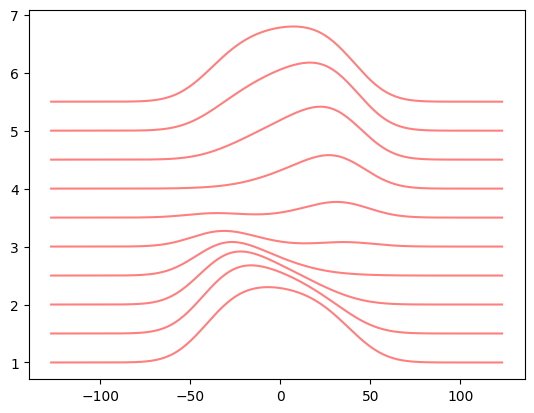

In [12]:
# for mod in model(vbins, vmids, 14.07, 24.45, 0.68, 0.2, 1.8, 15.99, 1.96783057337233, 1.7728610216685825)[:]:    
#     plt.plot(vmids, mod, c="k" , alpha=0.5)
off = 0
for mod in model(vbins, vmids, 0.1, -30, 60, 0., 1.3, 14.97, 1, 0)[:]:    
    plt.plot(vmids, mod+off, c="r" , alpha=0.5)
    off += 0.5



In [13]:
# make a mcmc setup with emcee
def log_likelihood(theta, vbins, vmids, y, yerr2):
    imag, phimin, dphi, alpha_0, ampl, broaden, amp_cos, off_cos = theta
    model_ = model(vbins, vmids, imag, phimin, dphi, alpha_0, ampl, broaden, amp_cos, off_cos)
    return  -0.5 * np.sum((y - model_) ** 2 / yerr2)
 
def log_prior(theta):
    imag, phimin, dphi, alpha_0, ampl, broaden, amp_cos, off_cos = theta
    if ((0 < imag < 90) and 
        (0 < np.abs(phimin) < 90) and 
        (5 < dphi < (90 - phimin)) and 
        (0 < alpha_0 < 1) and 
        (0 < ampl < 1e9) and 
        (5 < broaden < 25) and
        (0 < amp_cos < 20) and
        (0 < off_cos < np.pi)):
        return 0.0
    return -np.inf

def log_probability(theta, x, vmids, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, vmids, y, yerr)

initial = [42.53, 50, 12.01, 0.77, 1.2, 11.27, 0.30661857241410084, 2.116244855137751]
nwalkers = 32
ndim = len(initial)
pos = initial + 1e-1 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(vbins, vmids, ys, ystds**2),)
                                # backend=emcee.backends.HDFBackend("chain_high_lat_mod_ring.h5"))


sampler.run_mcmc(pos, 50, progress=True);

100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


In [14]:
sampler.run_mcmc(pos, 10000, progress=True);

 29%|██▉       | 2920/10000 [03:13<35:48,  3.30it/s]  Traceback (most recent call last):
  File "/home/ilin/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_143585/2496105858.py", line 24, in log_probability
    return lp + log_likelihood(theta, x, vmids, y, yerr)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_143585/2496105858.py", line 4, in log_likelihood
    model_ = model(vbins, vmids, imag, phimin, dphi, alpha_0, ampl, broaden, amp_cos, off_cos)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_143585/91981129.py", line 35, in model
    spectra = np.array([np.sum(spectra[i:i+subspecs], axis=0) for i in range(0, len(spectra), subspecs)])
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

emcee: Exception while calling your likelihood function:
  params: [2.18786719e+01 3.57240255e+01 5.74330606e+00 4.21658135e-03
 1.07510698e+00 2.49822499e+01 1.65349040e-01 3.14121420e+00]
  args: (array([-128.04263601, -126.72423067, -125.40582532, -124.08741998,
       -122.76901463, -121.45060929, -120.13220394, -118.8137986 ,
       -117.49539325, -116.17698791, -114.85858256, -113.54017722,
       -112.22177187, -110.90336653, -109.58496118, -108.26655583,
       -106.94815049, -105.62974514, -104.3113398 , -102.99293445,
       -101.67452911, -100.35612376,  -99.03771842,  -97.71931307,
        -96.40090773,  -95.08250238,  -93.76409704,  -92.44569169,
        -91.12728635,  -89.808881  ,  -88.49047565,  -87.17207031,
        -85.85366496,  -84.53525962,  -83.21685427,  -81.89844893,
        -80.58004358,  -79.26163824,  -77.94323289,  -76.62482755,
        -75.3064222 ,  -73.98801686,  -72.66961151,  -71.35120617,
        -70.03280082,  -68.71439547,  -67.39599013,  -66.0775847

KeyboardInterrupt: 

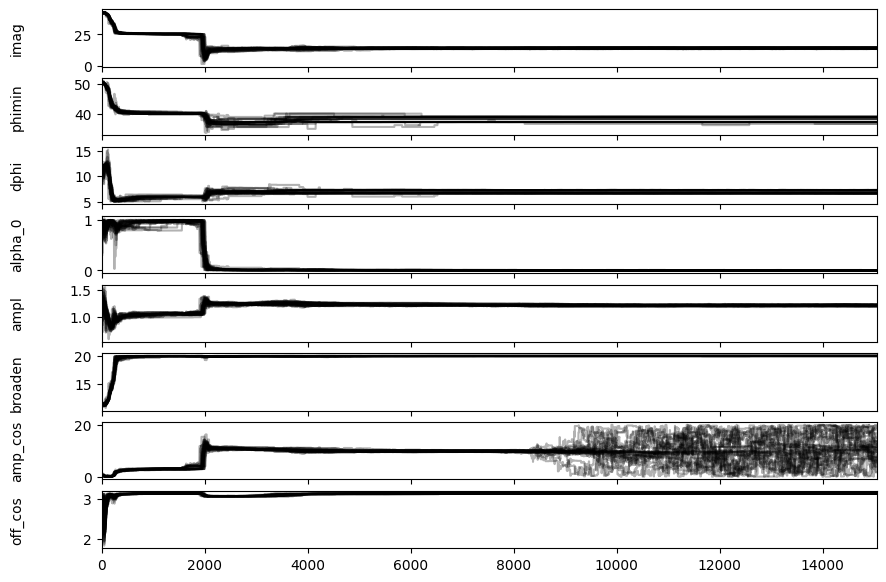

In [7]:
# plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["imag", "phimin", "dphi", "alpha_0", "ampl", "broaden", "amp_cos", "off_cos"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

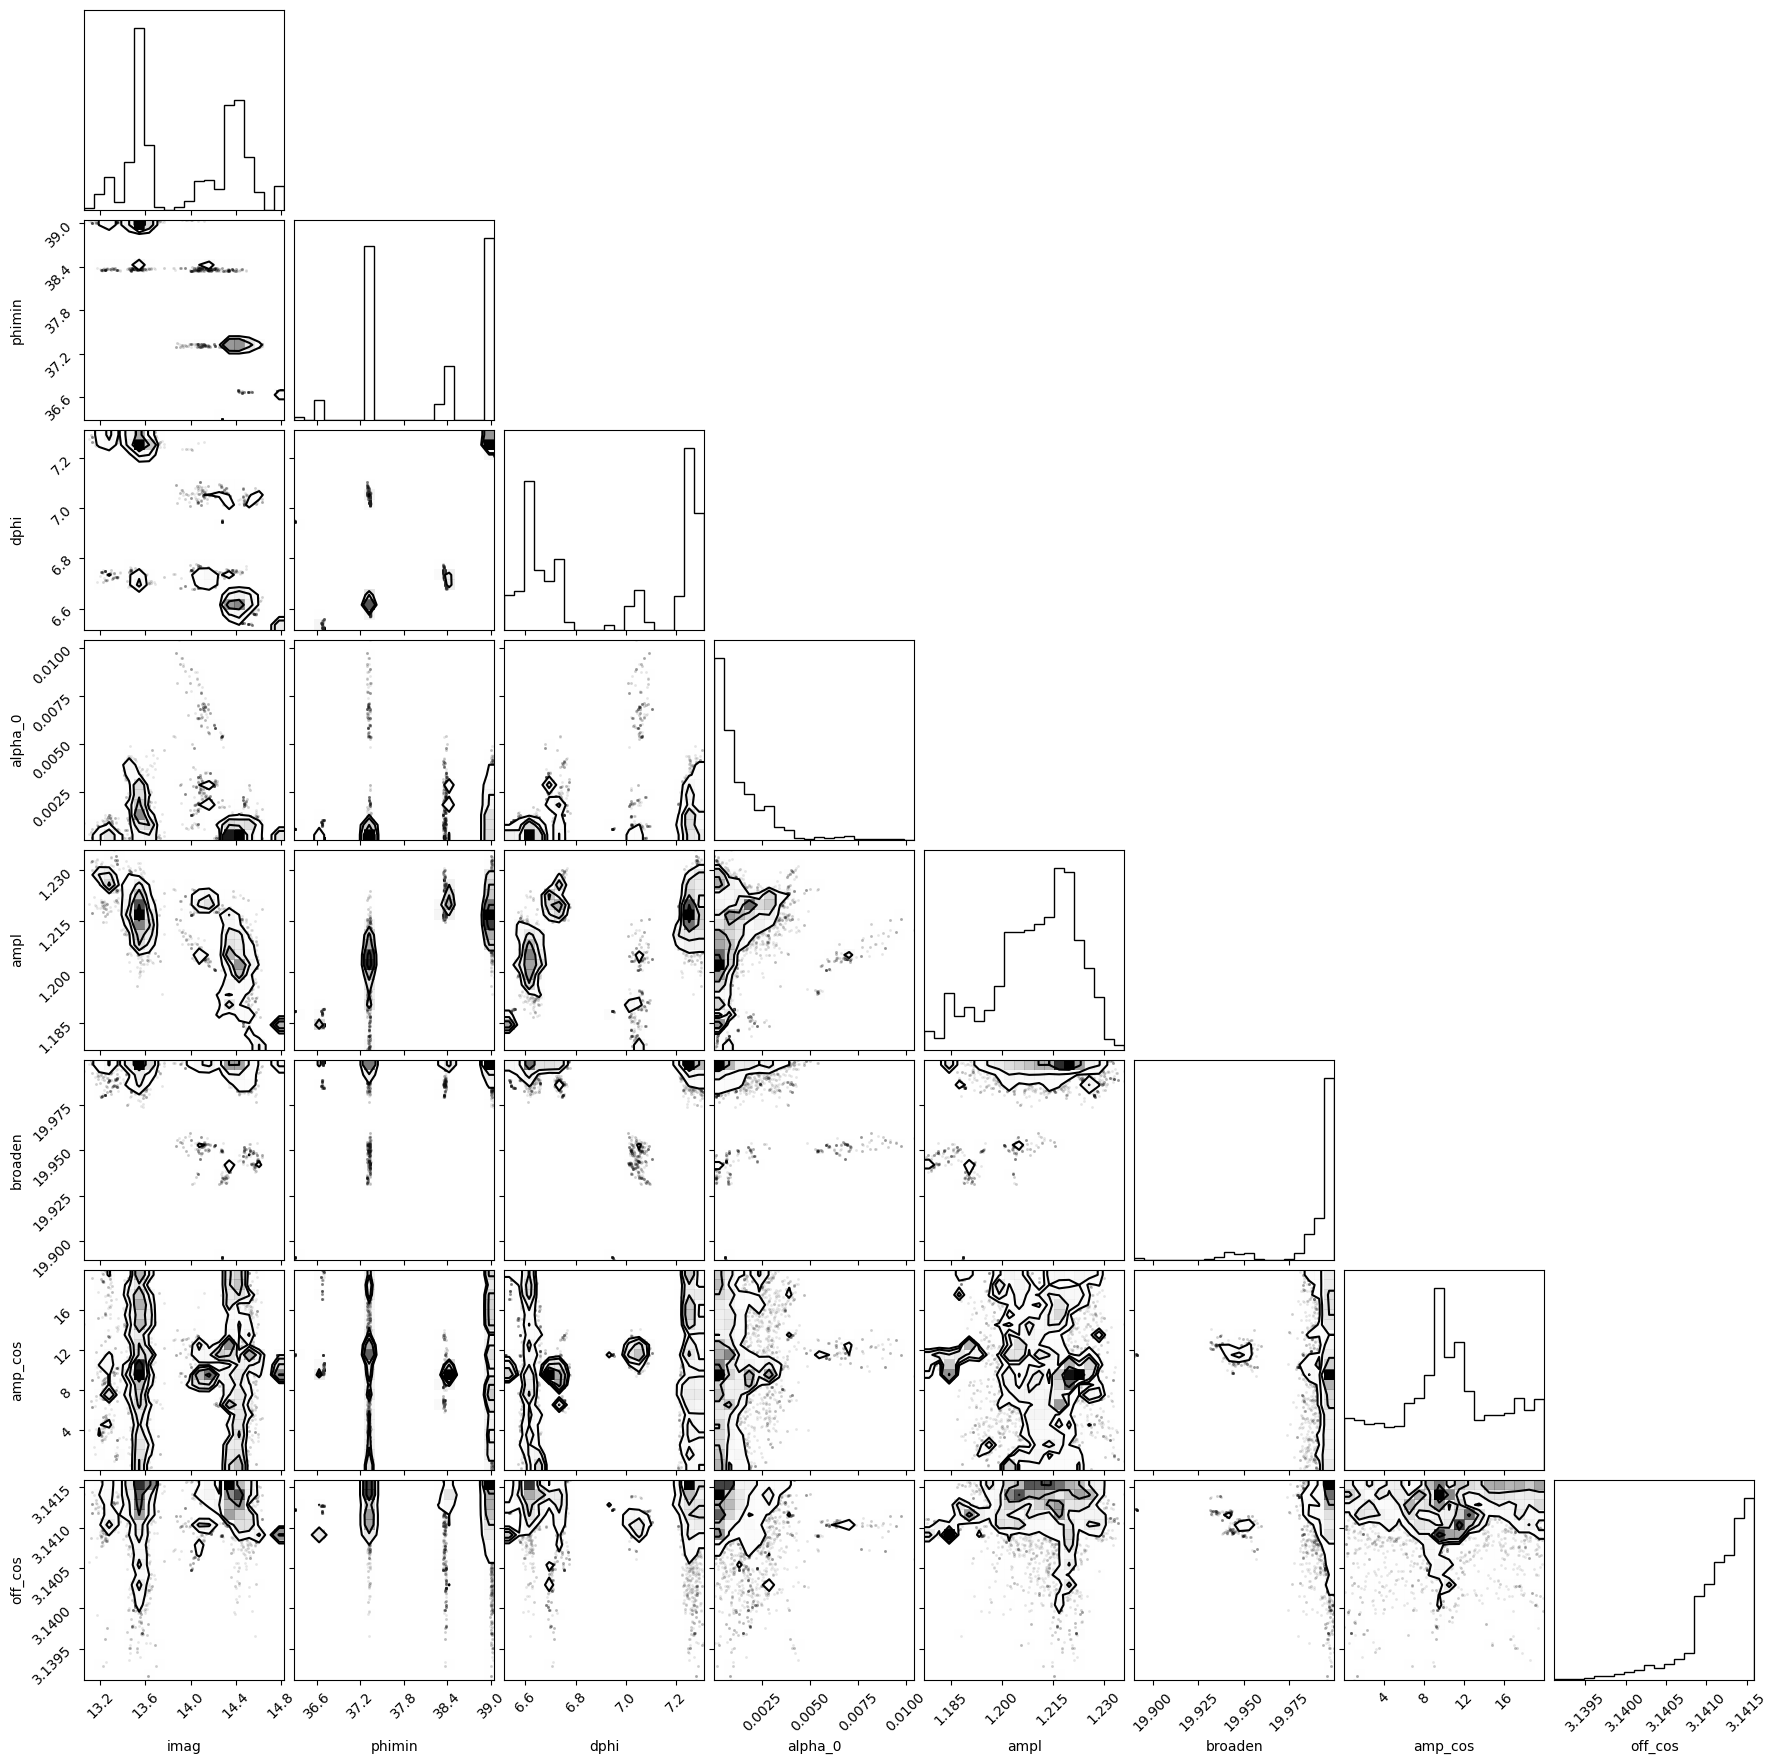

In [8]:
# corner plot
labels = ["imag", "phimin", "dphi", "alpha_0", "ampl", "broaden", "amp_cos", "off_cos"]

flat_samples = sampler.get_chain(discard=12000,
    # print(len(weights))
    # print(len(da))
    # print(weights.shape)
 thin=15, flat=True)
flat_samples = flat_samples

fig = corner.corner(
    flat_samples, labels=labels,)

14.07, 38.37, 6.86, 0.0, 1.21, 20.0, 10.206433263459505, 3.1412490356805898


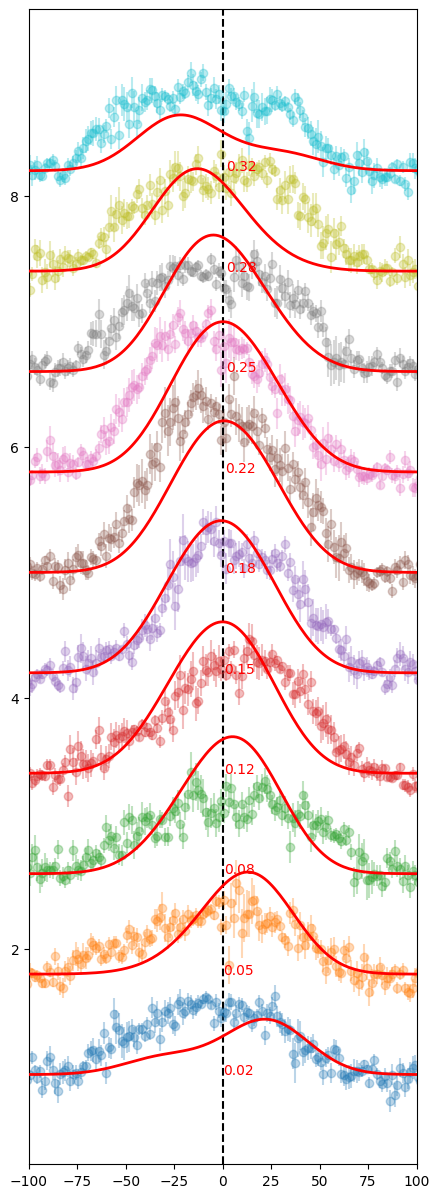

In [9]:
# plot best fit
imag, phimax, dphi, alpha_0, ampl, broaden, amp_cos, off_cos = np.median(flat_samples, axis=0)
v_mids = (vbins[1:] + vbins[:-1]) / 2
m = model(vbins, vmids, imag, phimax, 15, alpha_0, ampl, broaden,amp_cos*30, off_cos)

plt.figure(figsize=(5, 15))

offset = 0
for y, std in zip(ys, ystds):
    plt.errorbar(v_mids, y + offset, yerr=std, fmt='o', alpha=0.3)
    offset += .8

offset = 0
for i, mod in enumerate(m):
    plt.plot(v_mids, mod + offset, zorder=100, lw=2, c='r')
    # mark the maximum of the model
    # plt.scatter(v_mids[np.argmax(mod)], np.max(mod) + offset, c='r', s=100)
    plt.text(alphas_0[i], 1 + offset, f"{alphas_0[i]/np.pi/2:.2f}", c='r')
    offset += .8

plt.xlim(-100,100)
plt.axvline(0, c='k', ls='--')


# round up the values to 2 decimals and print them
imag, phimax, dphi, alpha_0, ampl, broaden = np.round([imag, phimax, dphi, alpha_0, ampl, broaden], 2)
print(f"{imag}, {phimax}, {dphi}, {alpha_0}, {ampl}, {broaden}, {amp_cos}, {off_cos}")

In [ ]:
alpha_0

obliquity, upper limit ring latitude, width ring, start_phase, relative amplitude, broadening[km/s]

22.51, 14.87, 0.36, 0.64, 0.99, 20.75